#### 6) Evaluating and Running Decoders with Stim

Again, we begin by importing the necessary packages:

In [19]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import copy
import datetime
import json
import os
import pickle
import sys

import gym
import keras
import numpy as np3
import rl as rl

# import shutilL
import tensorflow
from Environments import *
from Function_Library import *
from rl.agents.dqn import DQNAgent
from rl.callbacks import FileLogger
from rl.memory import SequentialMemory
from rl.policy import (
    BoltzmannQPolicy,
    EpsGreedyQPolicy,
    GreedyQPolicy,
    LinearAnnealedPolicy,
)
from Utils import *

Now, we need to load:
    
   1. The hyper-parameters of the agent we would like to test
   2. The weights of the agent
    
In this example we will evaluate one of the provided pre-trained decoders, for d=5, with X noise only, trained at an error rate of p_phys=p_meas=0.007

In [21]:
fixed_configs_path = os.path.join(os.getcwd(), "../trained_models/d5_x/fixed_config.p")
variable_configs_path = os.path.join(
    os.getcwd(), "../trained_models/d5_x/0.007/variable_config_77.p"
)
model_weights_path = os.path.join(
    os.getcwd(), "../trained_models/d5_x/0.007/final_dqn_weights.h5f"
)

static_decoder_path = os.path.join(os.getcwd(), "referee_decoders/nn_d5_X_p5")
static_decoder = load_model(static_decoder_path)

fixed_configs = pickle.load(open(fixed_configs_path, "rb"))
variable_configs = pickle.load(open(variable_configs_path, "rb"))

all_configs = {}

for key in fixed_configs.keys():
    all_configs[key] = fixed_configs[key]

for key in variable_configs.keys():
    all_configs[key] = variable_configs[key]

In [22]:
env = Surface_Code_Environment_Multi_Decoding_Cycles(
    d=all_configs["d"],
    p_phys=all_configs["p_phys"],
    p_meas=all_configs["p_meas"],
    error_model=all_configs["error_model"],
    use_Y=all_configs["use_Y"],
    volume_depth=all_configs["volume_depth"],
    static_decoder=static_decoder,
)

Now we build a model and instantiate an agent with all the parameters of the pre-trained agent. Notice that we insist on a greedy policy!

In [23]:
model = build_convolutional_nn(
    all_configs["c_layers"],
    all_configs["ff_layers"],
    env.observation_space.shape,
    env.num_actions,
)
memory = SequentialMemory(limit=all_configs["buffer_size"], window_length=1)
policy = GreedyQPolicy(masked_greedy=True)
test_policy = GreedyQPolicy(masked_greedy=True)
# ------------------------------------------------------------------------------------------

dqn = DQNAgent(
    model=model,
    nb_actions=env.num_actions,
    memory=memory,
    nb_steps_warmup=all_configs["learning_starts"],
    target_model_update=all_configs["target_network_update_freq"],
    policy=policy,
    test_policy=test_policy,
    gamma=all_configs["gamma"],
    enable_dueling_network=all_configs["dueling"],
)


dqn.compile(Adam(lr=all_configs["learning_rate"]))

At this stage the agent has random weights, and so we load in the weights of the pre-trained agent:

In [24]:
dqn.model.load_weights(model_weights_path)

##### Generating syndromes for the rotated surface code with stim

We would like to demonstrate how to use the decoder with stim. This allows us to simulate circuit level noise.

To do this, we start by generating syndromes from a surface code using stim

In [25]:
import stim

In [26]:
d = 5
batch_size = 1
p_phys = 0.008
# p_meas=p_phys

# circuit = stim.Circuit.generated(
#     "surface_code:rotated_memory_z",
#     rounds=d+1,
#     distance=5,
#     # before_round_data_depolarization=p_phys)
#     before_measure_flip_probability=p_meas)
# print(repr(circuit))

# check if qubit flips are applied in each syndrome measurement round!
circuit_file = open("sf-d5-memory.stim")
circuit_file = circuit_file.read().replace("0.007", str(p_phys))
circuit = stim.Circuit(circuit_file)
# print(circuit)

In [27]:
# This is for sampling from detectors (which introduces temporal dependencies)
detector_sampler = circuit.compile_detector_sampler()
shots = detector_sampler.sample(batch_size, append_observables=True)

# first cycle: (d**2-1)/2 detector measurements.
# second cycle:, (d**2-1)/2 X/Z and Z/X checks
detector_parts = shots[:, : circuit.num_detectors]
# logical observable along boundary
actual_observable_parts = shots[:, circuit.num_detectors :]

In [28]:
# mround = d**2 - 1

# for t in range(batch_size):
#     print()
#     for s in range(d+2):
#         print(detector_parts[t][s * mround : (s + 1) * mround])

Given the syndromes and observable, we extract the syndrome coordinates and transform the syndromes to a numpy array that gets accepted by the agent.

In [29]:
mround = d**2 - 1
syndrome_coords = circuit.get_detector_coordinates()
syndrome_coords = (
    np.array([syndrome_coords[e][0:2] for e in range(len(syndrome_coords))], int) // 2
)

def get_syndrome(syndromes, coords):
    faulty_syndrome = np.zeros((d + 1, d + 1), int)
    for e in range(len(syndromes)):
        i, j = coords[e]
        faulty_syndrome[i, j] = syndromes[e]
    # We need to flip the surface code around vertical axis
    # faulty_syndrome = np.fliplr(faulty_syndrome)
    faulty_syndrome = np.flipud(faulty_syndrome)
    return faulty_syndrome


faulty_syndromes = np.zeros((batch_size, d, d + 1, d + 1), int)
for t in range(batch_size):
    for s in range(d):
        faulty_syndromes[t][s] = get_syndrome(
            detector_parts[t][(s+1) * mround : (s + 2) * mround],
            syndrome_coords[(s+1) * mround : (s + 2) * mround],
        )

# detectors detect differences between time steps.
# We want absolute values for each time step.
for s in range(1, d):
    faulty_syndromes[:, s] += faulty_syndromes[:, s - 1]
    faulty_syndromes[:, s] = faulty_syndromes[:, s] % 2

In [30]:
# print(faulty_syndromes)

Now we would like to decode and obtain the suggested corrections. To do this, we begin by padding the faulty syndromes as required and by concatenating the obtained volume with an action history slice, in which all the actions are initially zero:

In [31]:
# Intialize a zero'd input volume
input_state = np.zeros((batch_size, d + 1, 2 * d + 1, 2 * d + 1), int)

# embed and place the faulty syndrome slices in the correct place
for t in range(batch_size):
    for j in range(d):
        # TODO: padding_syndrome is hardcoded for d=5??
        input_state[t, j, :, :] = env.padding_syndrome(faulty_syndromes[t][j])

And now we can run the agent, collecting the suggested actions, until the agent does the identity, which suggests that it is finished decoding:

In [32]:
corrections = []

for t in range(batch_size):
    corrections.append([])
    still_decoding = True
    while still_decoding:

        # Fetch the suggested correction
        action = dqn.forward(input_state[t])

        if action not in corrections[t] and action != env.identity_index:
            # If the action has not yet been done, or is not the identity

            # append the suggested correction to the list of corrections
            corrections[t].append(action)

            # Update the input state to the agent to indicate the correction it would have made
            input_state[t, d, :, :] = env.padding_actions(corrections[t])

        else:
            # decoding should stop
            still_decoding = False

And now we can view the suggested corrections, which in this case was a single correct suggestion:

In [33]:
# indicate which qubits have been flipped
corrected_state = np.zeros((batch_size, d, d), int)
for t in range(batch_size):
    print("-------------")
    for correction in corrections[t]:
        col = correction % d
        row = (correction - col) // d
        corrected_state[t, row, col] = 1
        print(f"Correcting qubit {correction} at ({row+1},{col+1})")
    print(f"Observable flipped: {actual_observable_parts[t][0]}")

-------------
Correcting qubit 23 at (5,4)
Observable flipped: False


Some pretty drawings to verify the results

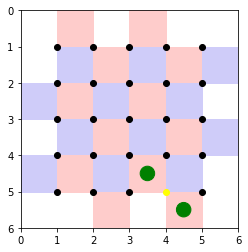

In [34]:
for t in range(batch_size):
    final_syndrome = get_syndrome(
        detector_parts[t][(d+1) * mround : -1], syndrome_coords[(d+1) * mround : -1]
    )
    draw_surface_code(corrected_state[t], env.syndromes, final_syndrome, env.d)
    # for s in range(d):
    #     draw_surface_code(env.hidden_state, env.syndromes, faulty_syndromes[t][s], env.d)

Note that in general if there is more than one error, or if the agent is uncertain about a given configuration, it may choose to do the identity, therefore triggering a new syndrome volume from which it may be more certain which action to take - The crucial point is that in practice we are interested in how long the qubit survives for, and an optimal strategy for achieving long qubit lifetimes may not be to attempt to fully decode into the ground state after each syndrome volume!